## 1. Load the data

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sb.set_palette("pastel")

In [ ]:
df = pd.read_csv('combined_csv.csv')

In [3]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 16 columns):
bike_id                    3254325 non-null int64
bike_share_for_all_trip    3254325 non-null object
duration_sec               3254325 non-null int64
end_station_id             3254325 non-null int64
end_station_latitude       3254325 non-null float64
end_station_longitude      3254325 non-null float64
end_station_name           3241824 non-null object
end_time                   3254325 non-null object
member_birth_year          3036159 non-null float64
member_gender              3036592 non-null object
start_station_id           3254325 non-null int64
start_station_latitude     3254325 non-null float64
start_station_longitude    3254325 non-null float64
start_station_name         3241824 non-null object
start_time                 3254325 non-null object
user_type                  3254325 non-null object
dtypes: float64(5), int64(4), object(7)
memory usage: 397.3+ MB


## 2. Prepare the data


- bike_share_for_all_trip with Null values
- time object fields as date object fields

new dimensions:
- member age missing
- date object fields as year, month, hour
- NULL values in end_station_id and start_station_id, meaning bikes not bound to stations
- transfer duration_sec in minutes
- route consisting of start and end location
- raw distance between the start and the end location

df['bike_share_for_all_trip2'] = df['bike_share_for_all_trip'].apply(lambda x: x if x in ('Yes', 'No') else 'Unknown')

from geopy.distance import geodesic
import time

start = time.time()
df2['distance'] = df2.apply(lambda x:
        geodesic((x['start_station_latitude'], x['start_station_longitude'])
        ,(x['end_station_latitude'], x['end_station_longitude'])), axis = 1)
end = time.time()
print(end - start)

In [ ]:
df.start_time = pd.to_datetime(df.start_time)
df['start_year'] = df.start_time.dt.year
df['member_age'] = df.start_time.dt.year - df.member_birth_year
df['start_year_month'] = df.start_year.astype(str).str[2:4] +'-'+df.start_time.dt.month.astype(str).str.zfill(2)
df['start_hour_minute'] = df.start_time.dt.hour+df.start_time.dt.minute/60
df['start_hour'] = df.start_time.dt.hour
df['start_day'] = df.start_time.dt.weekday_name
df['duration_minute']= round(df.duration_sec/ 60)
month_order_1 = ['17-01', '17-02','17-03','17-04','17-05','17-06','17-07','17-08','17-09','17-10','17-11','17-12',
                 '18-01', '18-02','18-03','18-04','18-05','18-06','18-07','18-08','18-09','18-10','18-11','18-12',
                 '19-01', '19-02','19-03','19-04']
month_order_2 = ['18-01', '18-02','18-03','18-04','18-05','18-06','18-07','18-08','18-09','18-10','18-11','18-12',
              '19-01', '19-02','19-03','19-04']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df = df.drop(columns='end_time')

In [5]:
df.bike_share_for_all_trip.fillna('Null', inplace = True)

In [6]:
df['dock_flg'] = df.start_station_id.notna()
df['route'] = df.start_station_name + ' - ' + df.end_station_name

## 3. Univariate Exploration

Dimensions to explore:
- time (year, month, week, day, time)
- bike_share_for_all_trip
- start- and endlocation by name and by latitude/longitude
- route by distance(technically that's already bivariate at least)
- duration
- member age
- member gender
- user type

Although this chapter is said to be about univariate exploration I am already going to use more than one dimension in several visualisations.

First taking a look on the time dimensions. Here we are seeing overall an increase of the rides over time, though in the cold months of the year the count falls.

In [ ]:
df_ratio_rides_to_bikes= df.groupby('start_year_month')['bike_id'].nunique().reset_index().merge(df.groupby(('start_year_month')).agg({'bike_id':'count'}).reset_index(), on='start_year_month')

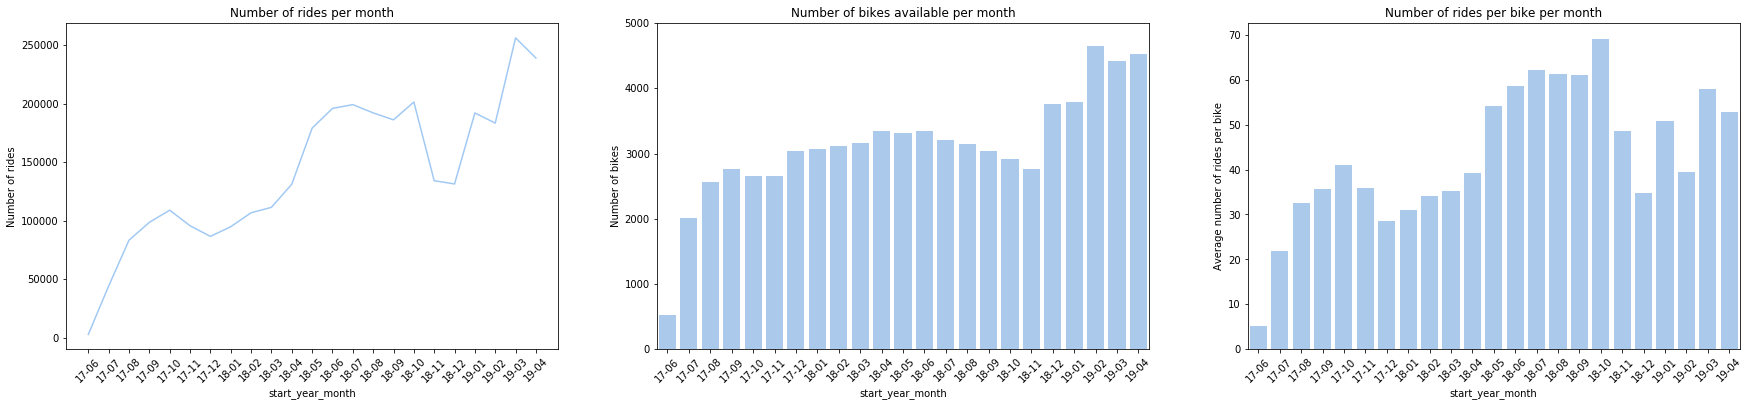

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.gcf().set_size_inches(30, 6)
#plt.setp(ax1.get_xticklabels(), rotation=45)
ax1 = sb.lineplot(data = df.groupby(('start_year_month')).agg({'bike_id':'count'}).reset_index(), x = 'start_year_month', y = 'bike_id', ax = ax1 )
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Number of rides per month')
ax1.set_ylabel('Number of rides')
#ax1.set_ylim(0, 250000)

ax2 = sb.barplot(data = df.groupby('start_year_month')['bike_id'].nunique().reset_index(), x = 'start_year_month', y = 'bike_id', color=sb.color_palette()[0], ax = ax2)
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Number of bikes available per month')
ax2.set_ylabel('Number of bikes')
ax2.set_ylim(0, 5000);

ax3 = sb.barplot(x = df_ratio_rides_to_bikes['start_year_month'], y = df_ratio_rides_to_bikes['bike_id_y']/df_ratio_rides_to_bikes['bike_id_x'], color=sb.color_palette()[0], ax = ax3)
plt.setp(ax3.get_xticklabels(), rotation=45)
ax3.set_title('Number of rides per bike per month')
ax3.set_ylabel('Average number of rides per bike');



ax = sb.lineplot(data = df.groupby(('start_year_month')).agg({'bike_id':'count'}).reset_index(), x = 'start_year_month', y = 'bike_id' )
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation = 25)
plt.title('Number of rides per month')
plt.ylabel('Number of rides');
#plt.ylim(0, 260000)

In [85]:
df['bike_id'].nunique()

6930

ax = sb.barplot(data = df.groupby('start_year_month')['bike_id'].nunique().reset_index(), x = 'start_year_month', y = 'bike_id', color=sb.color_palette()[0])
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation = 25)
plt.title('Number of bikes available per month')
plt.ylabel('Number of bikes')
plt.ylim(0, 5000);

ax = sb.barplot(x = df_ratio_rides_to_bikes['start_year_month'], y = df_ratio_rides_to_bikes['bike_id_y']/df_ratio_rides_to_bikes['bike_id_x'], color=sb.color_palette()[0])
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation = 25)
plt.title('Number of rides per bike per month')
plt.ylabel('Average number of rides per bike');
#plt.ylim(0, 5000);

(0, 400)

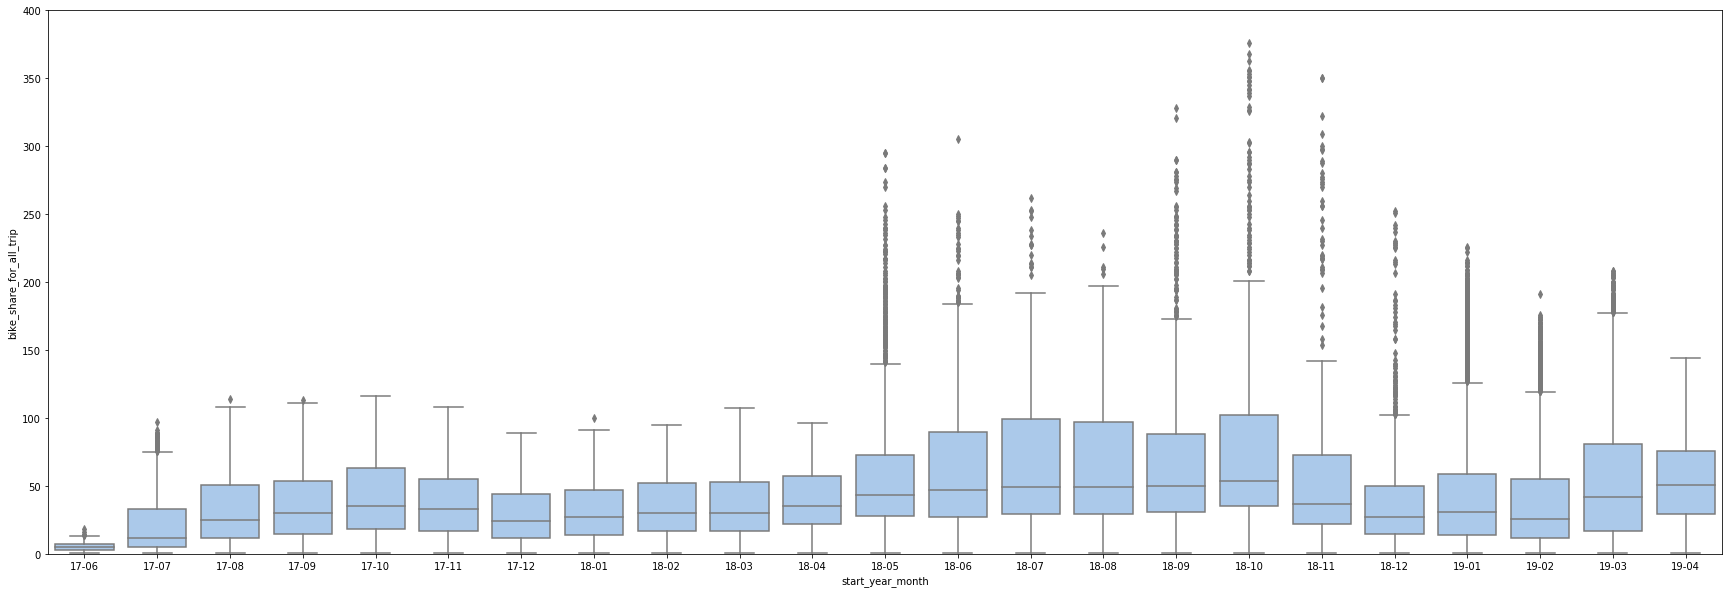

In [88]:
sb.boxplot(data = df.groupby(['start_year_month', 'bike_id']).agg({'bike_share_for_all_trip': 'count'}).reset_index()
              , x = 'start_year_month', y = 'bike_share_for_all_trip', color =  sb.color_palette()[0])
plt.gcf().set_size_inches(30, 10);
plt.ylim(0, 400)

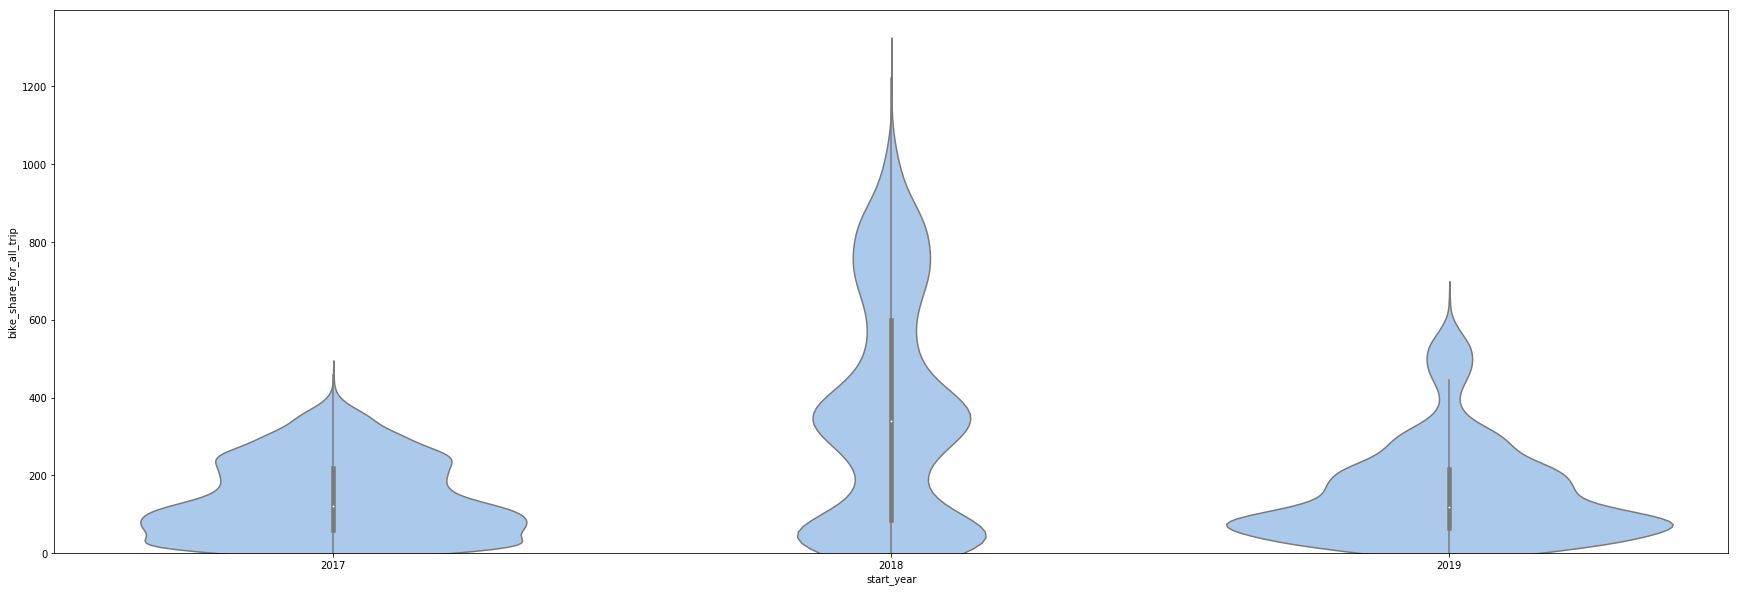

In [89]:
sb.violinplot(data = df.groupby(['start_year', 'bike_id']).agg({'bike_share_for_all_trip': 'count'}).reset_index()
              , x = 'start_year', y = 'bike_share_for_all_trip', color =  sb.color_palette()[0])
plt.gcf().set_size_inches(30, 10);
plt.ylim(0, );

The 'Bike Share for All' membership is an exclusive membership for people with low income. It costs just \$ 5 in the first year and from the second year on every month \$ 5 which is im comparision to the regular membership with \$ 15 per month or \$ 149 per Year still quite cheap. Included are rides until 60 minutes while for the the regular membership it's until 45 minutes. In the following monthly comparision there is no differentiation of the memberships before 2018. Although in the first visualisation the decrease of the number of rides in the cold months and the general increase seems to be much higher for the regular subscribers that's only because it's movements can be read much better on the given scale of the y axis. As you can see in the second visualisation the share of 'Bike Share for All' rides remmains pretty stable so it's development is correlating to the rest.

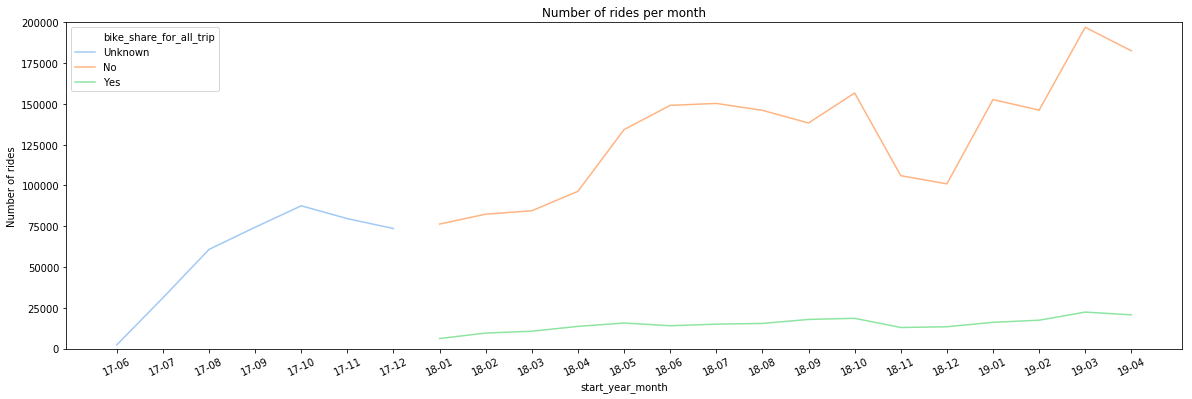

In [90]:
ax = sb.lineplot(data = df[df['user_type']=='Subscriber'].groupby(['start_year_month', 'bike_share_for_all_trip']).agg({'bike_id':'count'}).reset_index(), x = 'start_year_month', y = 'bike_id' ,hue = 'bike_share_for_all_trip')
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation = 25)
plt.title('Number of rides per month')
plt.ylabel('Number of rides')
plt.ylim(0, 200000);

In [91]:
df_share_discount = df[df['user_type']=='Subscriber'].groupby('start_year_month')['bike_share_for_all_trip'].value_counts(normalize=True).rename('percentage').reset_index()

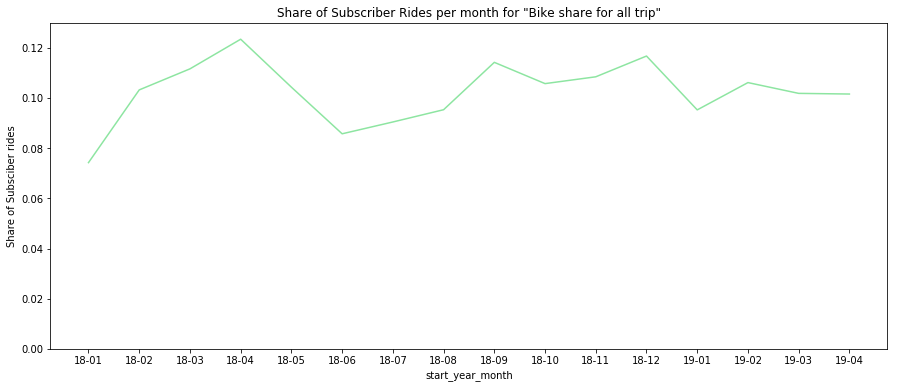

In [92]:
plt.figure(figsize=(15, 6))
sb.lineplot(data = df_share_discount[df_share_discount['bike_share_for_all_trip']=='Yes'], x = 'start_year_month', y = 'percentage', color=sb.color_palette()[2])
plt.title('Share of Subscriber Rides per month for "Bike share for all trip"')
plt.ylabel('Share of Subsciber rides')
#plt.xticks(rotation = 45)
plt.ylim(0,0.13);

In [93]:
df['user_type_mod'] = df.apply(lambda x: 'Subscriber Discount' if x['bike_share_for_all_trip'] == 'Yes' else x['user_type'], axis=1)

KeyboardInterrupt: 

In [94]:
df['user_type_mod'].value_counts()

Subscriber             2508834
Customer                506745
Subscriber Discount     238746
Name: user_type_mod, dtype: int64

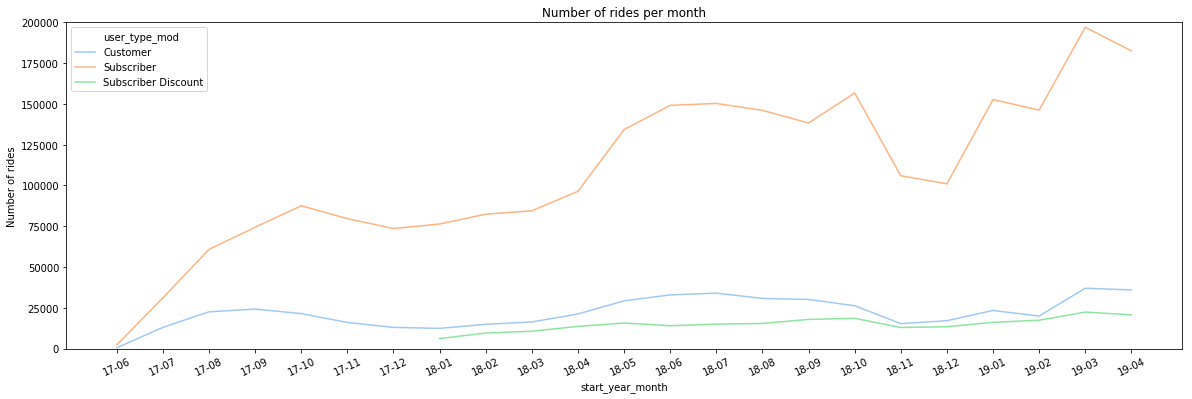

In [95]:
ax = sb.lineplot(data = df.groupby(['start_year_month', 'user_type_mod']).agg({'bike_id':'count'}).reset_index(), x = 'start_year_month', y = 'bike_id' ,hue = 'user_type_mod')
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation = 25)
plt.title('Number of rides per month')
plt.ylabel('Number of rides')
plt.ylim(0, 200000);

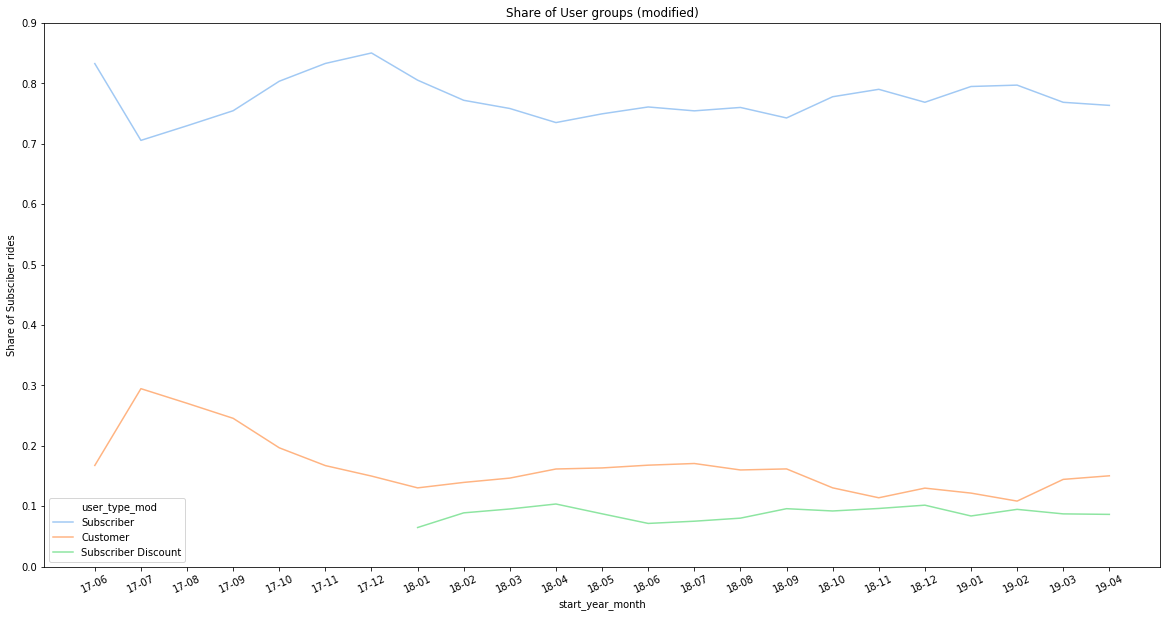

In [96]:
plt.figure(figsize=(20, 10))
sb.lineplot(data = df.groupby('start_year_month')['user_type_mod'].value_counts(normalize=True).rename('percentage').reset_index()
           , x = 'start_year_month', y = 'percentage', hue= 'user_type_mod' )
plt.title('Share of User groups (modified)')
plt.ylabel('Share of Subsciber rides')
plt.xticks(rotation = 25)
plt.ylim(0,0.9);

What is noticable:
- a high share for Customers right at the kickoff of the programm
- some decline of the share for Customers in the colder months
- the share for Discount Subscribrs seems to be more or less stable despite some decline in the months from may to august, so it development correlates to the genereal development. 

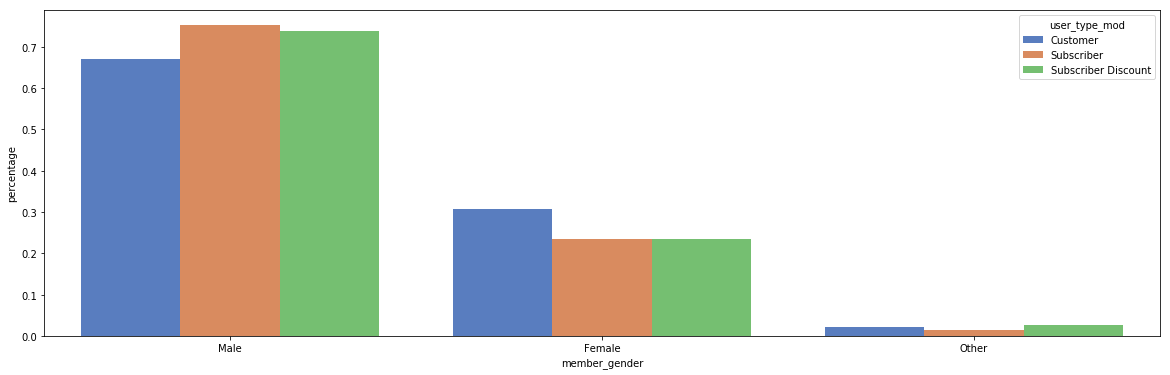

In [112]:
plt.figure(figsize=(20, 6))
sb.barplot(data= df.groupby('user_type_mod')['member_gender'].value_counts(normalize=True).rename('percentage').reset_index(), hue='user_type_mod', y='percentage', x = 'member_gender')
#plt.ylim(0, 80)

What is noticeable:
- there a slightly more females in the customer user type

In [98]:
df_user_type_age_share =df.groupby('user_type_mod')['member_age'].value_counts(normalize=True).rename('percentage').reset_index()

C:\Users\Tatze-Teclast\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


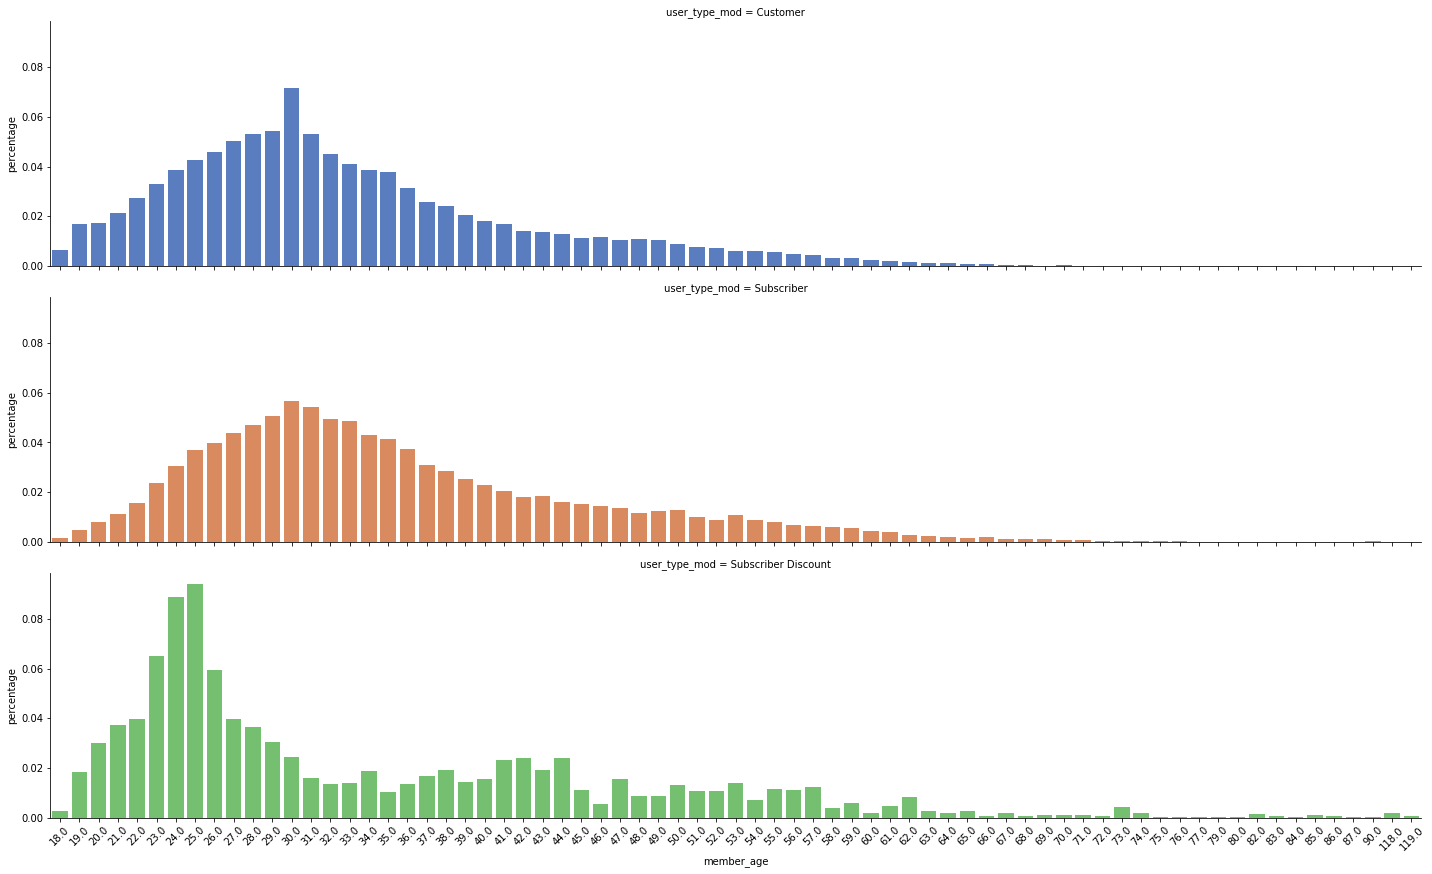

In [113]:
g = sb.FacetGrid(df_user_type_age_share,row ='user_type_mod', hue = 'user_type_mod', height =4, aspect = 5)
g.map(sb.barplot,  'member_age',  'percentage')
plt.xticks(rotation = 45);

What is noticeable:
- the high share of 23 to 26 years old people in the Discount Subscribers Here I'm not really used to the background of the programm
- a kind of peak that is to high at 30 for the Customers
- while distribution for Subscribers and Customers seems to be quite forcastable the distributio for the Discount Subscribers is quite chaotic.

In [100]:
df_user_type_weekday_share =df.groupby('user_type_mod')['start_day'].value_counts(normalize=True).rename('percentage').reset_index()

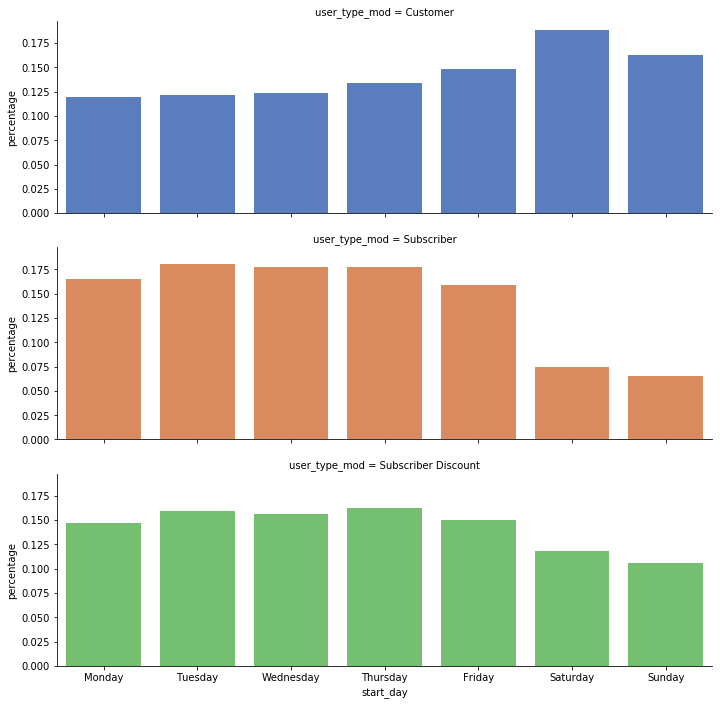

In [114]:
g = sb.FacetGrid(data = df_user_type_weekday_share, row = 'user_type_mod', hue = 'user_type_mod', sharey=True)
g.map(sb.barplot, 'start_day', 'percentage', order = day_order)
plt.gcf().set_size_inches(15, 10)


In [102]:
df.sample()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,start_year,member_age,start_year_month,start_hour_minute,start_hour,start_day,duration_minute,dock_flg,route,user_type_mod
2108883,2218,No,637,17,37.792251,-122.397086,Embarcadero BART Station (Beale St at Market St),1971.0,Male,58,37.776619,-122.417385,Market St at 10th St,2019-02-21 16:22:46.966,Subscriber,2019,48.0,19-02,16.366667,16,Thursday,11.0,True,Market St at 10th St - Embarcadero BART Station (Beale St at Market St),Subscriber


In [103]:
df_user_type_weekday_time_share =df.groupby(['user_type_mod','start_day'])[ 'start_hour'].value_counts(normalize=True).rename('percentage').reset_index()

C:\Users\Tatze-Teclast\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


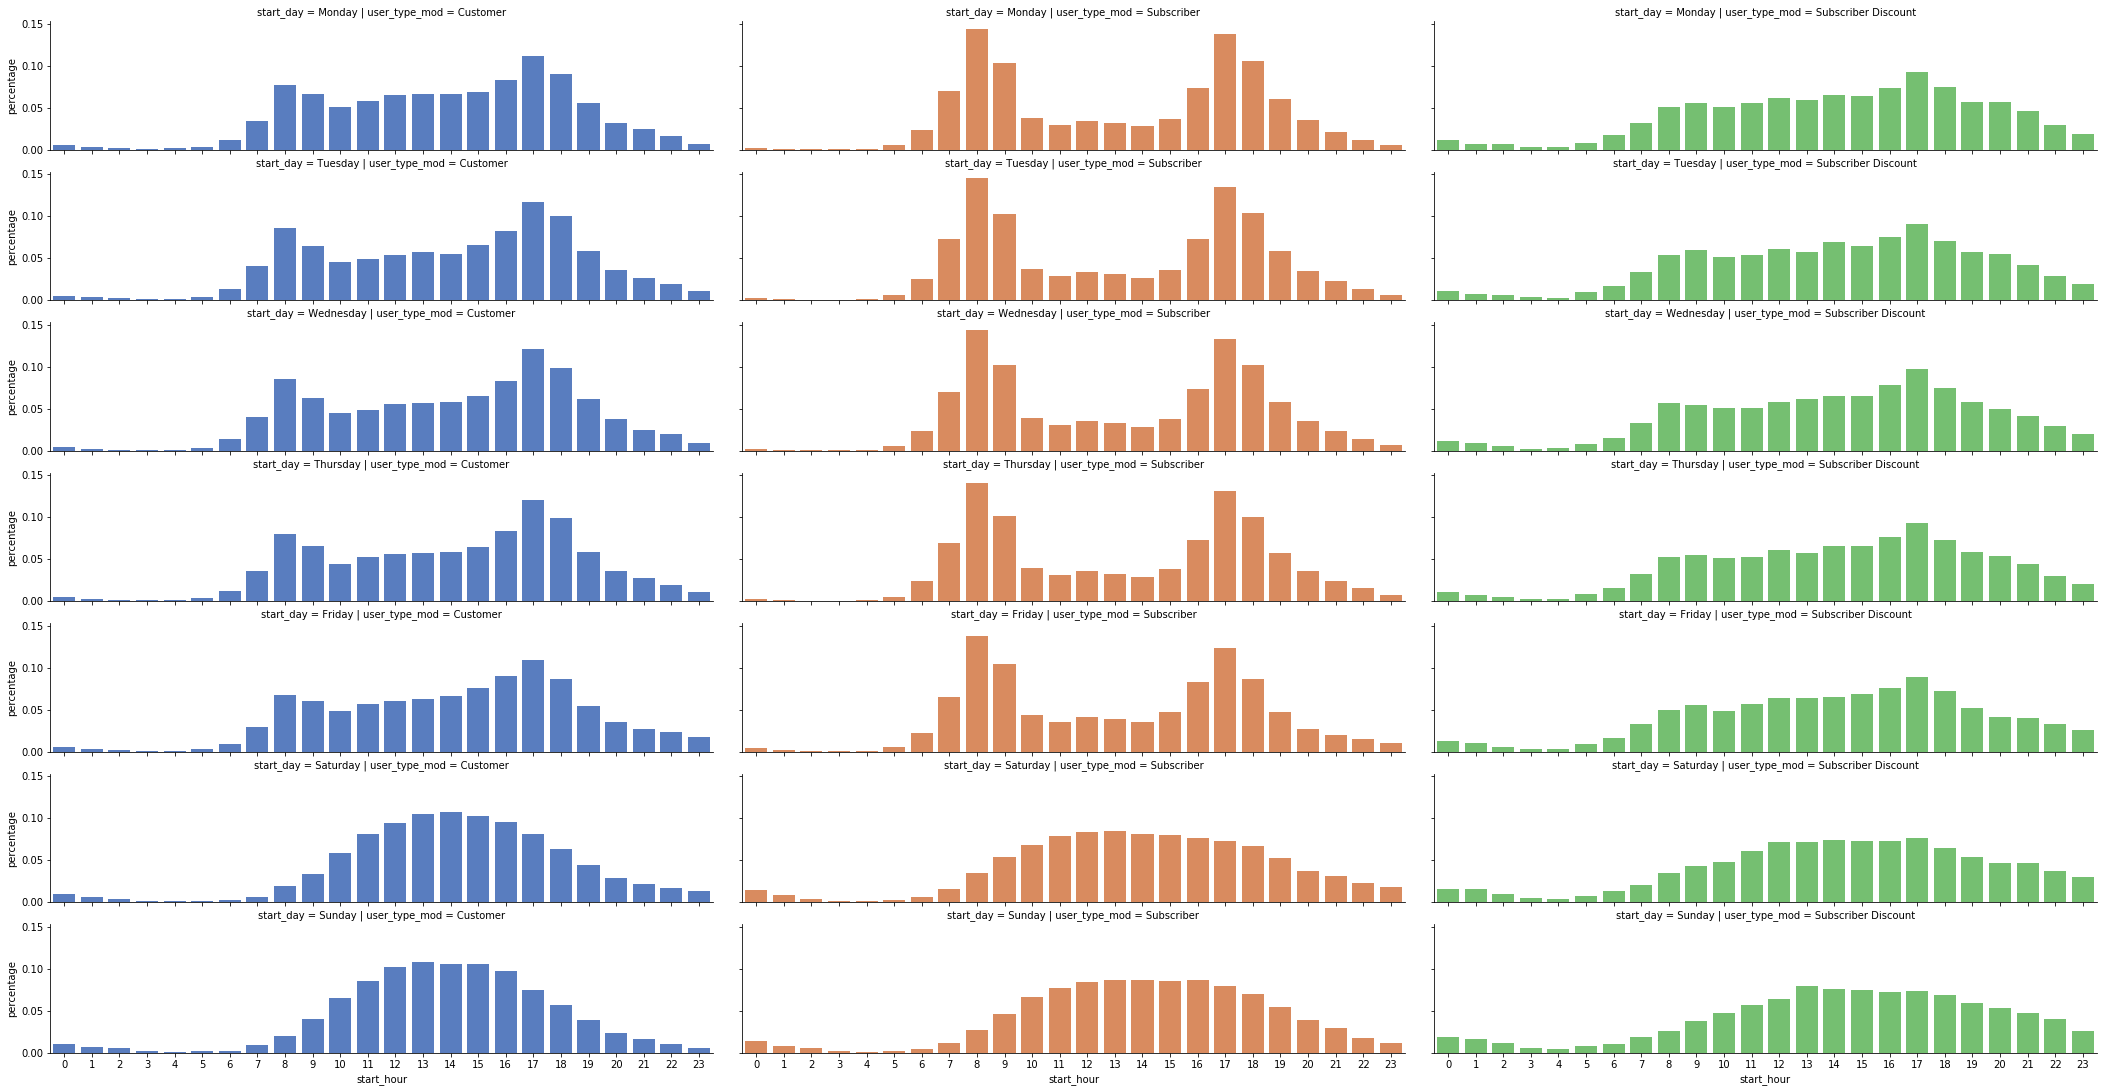

In [115]:
g = sb.FacetGrid(data = df_user_type_weekday_time_share, col = 'user_type_mod', row='start_day', hue = 'user_type_mod', row_order=day_order,sharey=True,sharex=True, aspect = 2)
g.map(sb.barplot, 'start_hour', 'percentage')
plt.gcf().set_size_inches(30, 15)


In [105]:
df_user_type_location_share = df.groupby('user_type_mod')['start_station_name'].value_counts(normalize=True).rename('percentage').reset_index()

In [106]:
df_user_type_location_share[df_user_type_location_share['user_type_mod']=='Customer'].head()

,user_type_mod,start_station_name,percentage
0,Customer,San Francisco Ferry Building (Harry Bridges Plaza),0.040558
1,Customer,The Embarcadero at Sansome St,0.040526
2,Customer,Powell St BART Station (Market St at 4th St),0.023191
3,Customer,Powell St BART Station (Market St at 5th St),0.017442
4,Customer,The Embarcadero at Vallejo St,0.015110


In [107]:
df_user_type_location_share[df_user_type_location_share['user_type_mod']=='Subscriber'].head()

,user_type_mod,start_station_name,percentage
392,Subscriber,San Francisco Caltrain Station 2 (Townsend St at 4th St),0.023739
393,Subscriber,Market St at 10th St,0.022100
394,Subscriber,San Francisco Caltrain (Townsend St at 4th St),0.020910
395,Subscriber,Berry St at 4th St,0.020037
396,Subscriber,Montgomery St BART Station (Market St at 2nd St),0.019096


In [108]:
df_user_type_location_share[df_user_type_location_share['user_type_mod']=='Subscriber Discount'].head()

,user_type_mod,start_station_name,percentage
783,Subscriber Discount,5th St at Virginia St,0.042859
784,Subscriber Discount,San Fernando St at 4th St,0.039828
785,Subscriber Discount,Bancroft Way at College Ave,0.022331
786,Subscriber Discount,Ryland Park,0.021663
787,Subscriber Discount,Bancroft Way at Telegraph Ave,0.021209


## 4. Multivariate Exploration

Possible mulitvariarte Questions:
1. How is the User Type different?
    - Is he of different age and gender?
    - Is he using the bike for a longer time/distance?
    - Is he using other routes and stations?
    - Is he using the bikes on different months, days and daytimes?
    
2. Might there be a difference between young, middle age and old people?
    - Gender, User Type, bike_share_for_all_trip?
    - Usage for different time/distance?
    - Different times and stations?
    - Different months, days and daytimes?
 
3. bike_share_for_all_trip
    - Gender, User Type, Age?
    - Usage for different time/distance?
    - Different times and stations?
    - Different months, days and daytimes?

4. Gender
    - Gender, User Type, bike_share_for_all_trip?
    - Usage for different time/distance?

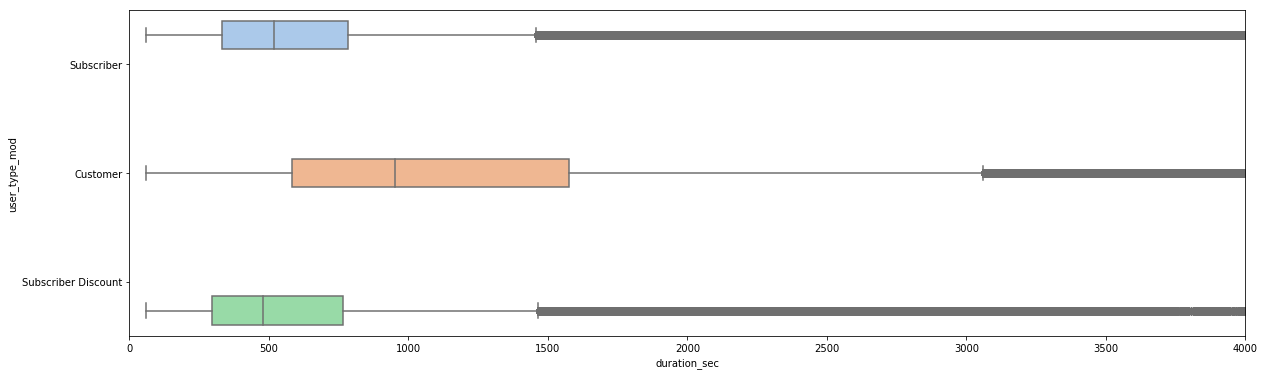

In [109]:
plt.figure(figsize=(20, 6))
sb.boxplot(data=df, y = 'user_type_mod', x = 'duration_sec', hue = 'user_type_mod')
plt.xlim(0, 4000)
#plt.yscale('log', basey = 2)
#plt.xticks(rotation = 15);
plt.legend().set_visible(False)
#plt.get_legend().remove_legend()

In [38]:
df_bike = pd.DataFrame(df[['bike_id', 'start_year_month']].groupby(['start_year_month','bike_id']).size()).reset_index()

In [39]:
df_start_geo = df[df.start_station_id.notna()].groupby(['start_station_latitude', 'start_station_longitude'])
df_start_geo = pd.DataFrame(df.groupby(['start_station_latitude', 'start_station_longitude']).count()['duration_sec'])

In [40]:
df_start_geo = df_start_geo.reset_index()

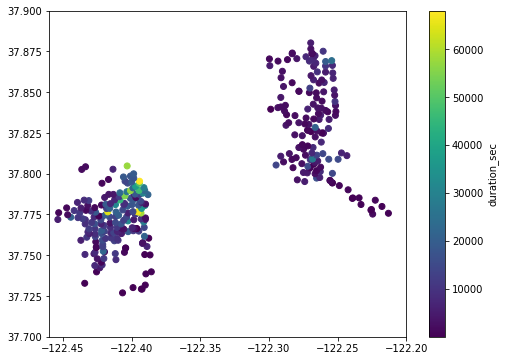

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(data = df_start_geo, y = 'start_station_latitude', x = 'start_station_longitude', c = 'duration_sec')
plt.ylim(37.7, 37.9)
plt.xlim(-122.46, -122.2)
#plt.ylim(37.72, 37.82)
#plt.xlim(-122.46, -122.36)
#plt.ylim(37.77, 37.89)
#plt.xlim(-122.32, -122.20)
plt.colorbar(label = 'duration_sec')